In [4]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


Rating and Sentiment Score Threshold

In [5]:
import pandas as pd
from textblob import TextBlob

df = pd.read_csv('final_dataset.csv')

combined_rating = df['stars'].mean()

rating_threshold = combined_rating

df['sentiment_score'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

combined_sentiment_score = df['sentiment_score'].mean()

sentiment_threshold = combined_sentiment_score

df['rule1_threshold'] = df.apply(lambda row: 0 if row['stars'] < rating_threshold and row['sentiment_score'] < sentiment_threshold else 1, axis=1)

df.to_csv('threshold.csv', index=False)

num_filtered_reviews = len(df)
rule_counts = df['rule1_threshold'].value_counts()

print("Count of reviews with rule1_threshold equal to 0 and 1:")
print(rule_counts)
print(f"Rating Threshold: {rating_threshold}")
print(f"Sentiment Score Threshold: {sentiment_threshold}")
print(f"Number of Reviews: {num_filtered_reviews}")


Count of reviews with rule1_threshold equal to 0 and 1:
rule1_threshold
1    41102
0    12358
Name: count, dtype: int64
Rating Threshold: 3.8563973063973065
Sentiment Score Threshold: 0.23259107181563363
Number of Reviews: 53460


Useful Count Threshold Calculation

In [6]:
import pandas as pd

threshold_df = pd.read_csv('threshold.csv')

average_useful = threshold_df['useful'].mean()

threshold = average_useful

threshold_df['rule5_threshold'] = threshold_df['useful'].apply(lambda x: 1 if x > threshold else 0)

threshold_df.to_csv('threshold.csv', index=False)

above_threshold_count = threshold_df[threshold_df['useful'] > threshold].shape[0]
below_threshold_count = threshold_df[threshold_df['useful'] <= threshold].shape[0]

print(f'Average useful counts of all reviews: {average_useful}')
print(f'Number of reviews above threshold: {above_threshold_count}')
print(f'Number of reviews below threshold: {below_threshold_count}')


Average useful counts of all reviews: 2.151889263000374
Number of reviews above threshold: 15213
Number of reviews below threshold: 38247


Average Length Threshold

In [7]:
import pandas as pd

threshold_df = pd.read_csv('threshold.csv')

average_text_length = threshold_df['text'].apply(len).mean()

threshold = average_text_length

threshold_df['rule2_threshold'] = threshold_df['text'].apply(lambda x: 1 if len(x) > threshold else 0)

threshold_df.to_csv('threshold.csv', index=False)

print("Average Text Length:", average_text_length)
print("Threshold Value:", threshold)
print("Number of Reviews Above Threshold:", (threshold_df['rule2_threshold'] == 1).sum())
print("Number of Reviews Below or Equal to Threshold:", (threshold_df['rule2_threshold'] == 0).sum())


Average Text Length: 773.362532734755
Threshold Value: 773.362532734755
Number of Reviews Above Threshold: 20194
Number of Reviews Below or Equal to Threshold: 33266


In [2]:
!python -m spacy download en_core_web_md


     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     --------------------------------------- 0.0/42.8 MB 388.9 kB/s eta 0:01:50
     --------------------------------------- 0.1/42.8 MB 655.4 kB/s eta 0:01:06
     ---------------------------------------- 0.2/42.8 MB 1.4 MB/s eta 0:00:32
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:31
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:30
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:30
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:30
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:30
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:30
     ---------------------------------------- 0.3/42.8 MB 1.4 MB/s eta 0:00:30
     ---------------------------------------- 0.3/42.8 MB 1.4 MB

Rating with Timeframe

In [8]:
import pandas as pd

df = pd.read_csv('threshold.csv')

df['date'] = pd.to_datetime(df['date'])

user_reviews_per_day = df.groupby(['user_id', df['date'].dt.date]).size()

combined_avg_reviews_per_day = user_reviews_per_day.mean()

threshold_reviews_per_day = combined_avg_reviews_per_day

combined_rating = df['stars'].mean()

threshold_rating = combined_rating  

filtered_users = user_reviews_per_day[(user_reviews_per_day > threshold_reviews_per_day)].reset_index()

filtered_reviews = df[df['user_id'].isin(filtered_users['user_id'])]
filtered_reviews = filtered_reviews[filtered_reviews['stars'] < threshold_rating]

df['rule4_threshold'] = 1  
df.loc[df['review_id'].isin(filtered_reviews['review_id']), 'rule4_threshold'] = 0  

df.to_csv('threshold.csv', index=False)

num_filtered_reviews = len(filtered_reviews)
print(f"Reviews per Day Threshold: {threshold_reviews_per_day}")
print(f"Rating Threshold: {threshold_rating}")
print(f"Number of Filtered Reviews: {num_filtered_reviews}")


Reviews per Day Threshold: 1.0884215241158866
Rating Threshold: 3.8563973063973065
Number of Filtered Reviews: 7716


In [9]:
pip install datasketch

Note: you may need to restart the kernel to use updated packages.


Rule 6 : User id, Similarity Score, Time Threshold

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from datasketch import MinHash, MinHashLSH

df = pd.read_csv('threshold.csv')

df['date'] = pd.to_datetime(df['date'])

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

num_perm = 128

lsh = MinHashLSH(threshold=0.7, num_perm=num_perm)

minhashes = []
for i in range(len(df)):
    text = df.iloc[i]['text']
    words = text.split()
    minhash = MinHash(num_perm=num_perm)
    for word in words:
        minhash.update(word.encode('utf-8'))
    lsh.insert(i, minhash)
    minhashes.append(minhash)

def calculate_similarity(row):
    query_text = row['text']
    query_minhash = MinHash(num_perm=num_perm)
    for word in query_text.split():
        query_minhash.update(word.encode('utf-8'))
    
    similar_indices = lsh.query(query_minhash)
    
    similarities = []
    for idx in similar_indices:
        similarities.append(minhashes[idx].jaccard(query_minhash))
    
    return max(similarities)

df['similarity_score'] = df.apply(calculate_similarity, axis=1)

user_similarity = df.groupby('user_id')['similarity_score'].mean()

user_time_difference = df.groupby('user_id')['date'].apply(lambda x: (x.max() - x.min()).total_seconds()).mean()

def calculate_threshold(user_similarity, user_time_difference):
    threshold = user_similarity * user_time_difference
    return threshold

threshold = calculate_threshold(user_similarity.mean(), user_time_difference)

df['rule6_threshold'] = df['similarity_score'].apply(lambda score: 0 if score > threshold else 1)

df.to_csv('threshold.csv', index=False)

print(f'Threshold: {threshold}')
print(f'Number of reviews above threshold: {df[df["rule6_threshold"] == 0].shape[0]}')
print(f'Number of reviews below threshold: {df[df["rule6_threshold"] == 1].shape[0]}')


Threshold: 39720459.39412263
Number of reviews above threshold: 0
Number of reviews below threshold: 53460


Rule 3 Similarity Score within the time frame

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from datasketch import MinHash, MinHashLSH

df = pd.read_csv('threshold.csv')

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

num_perm = 128

lsh = MinHashLSH(threshold=0.7, num_perm=num_perm)

minhashes = []
for i in range(len(df)):
    text = df.iloc[i]['text']
    words = text.split()
    minhash = MinHash(num_perm=num_perm)
    for word in words:
        minhash.update(word.encode('utf-8'))
    lsh.insert(i, minhash)
    minhashes.append(minhash)

similar_reviews_indices = []
for i, minhash in enumerate(minhashes):
    similar_indices = lsh.query(minhash)
    similar_indices = [idx for idx in similar_indices if idx != i]
    for j in similar_indices:
        similar_reviews_indices.append((i, j))

similar_reviews_df = df.iloc[[index for pair in similar_reviews_indices for index in pair]]

df['rule3_threshold'] = df.apply(lambda row: 0 if row.name in similar_reviews_df.index else 1, axis=1)

df.to_csv('threshold.csv', index=False)

num_similar_reviews = len(similar_reviews_df)
print(f"Number of Similar Reviews: {num_similar_reviews}")

Number of Similar Reviews: 372


Adding of target attribute

In [12]:
import pandas as pd

df = pd.read_csv('threshold.csv')

columns_to_check = ['rule1_threshold', 'rule2_threshold', 'rule3_threshold', 'rule4_threshold', 'rule5_threshold', 'rule6_threshold']

df['count_ones'] = df[columns_to_check].sum(axis=1)

df['target'] = df['count_ones'].apply(lambda x: 'genuine' if x > 3 else 'fake')

df.to_csv('final_dataset.csv', index=False)

No of fake and Genuine

In [13]:
import pandas as pd

df = pd.read_csv('final_dataset.csv')

target_counts = df['target'].value_counts()

print("Number of texts labeled as 'genuine':", target_counts['genuine'])
print("Number of texts labeled as 'fake':", target_counts['fake'])


Number of texts labeled as 'genuine': 44847
Number of texts labeled as 'fake': 8613


Sarcasam Detection

In [14]:
import pandas as pd

threshold_df = pd.read_csv('final_dataset.csv')

average_useful = threshold_df['funny'].mean()

threshold = average_useful

threshold_df['funny_threshold'] = threshold_df['funny'].apply(lambda x: 1 if x > threshold else 0)

threshold_df.to_csv('final_dataset.csv', index=False)

above_threshold_count = threshold_df[threshold_df['funny'] > threshold].shape[0]
below_threshold_count = threshold_df[threshold_df['funny'] <= threshold].shape[0]

print(f'Average useful counts of all reviews: {average_useful}')
print(f'Number of reviews above threshold: {above_threshold_count}')
print(f'Number of reviews below threshold: {below_threshold_count}')


Average useful counts of all reviews: 0.8245604190048634
Number of reviews above threshold: 17714
Number of reviews below threshold: 35746


In [15]:
import pandas as pd

threshold_df = pd.read_csv('final_dataset.csv')

average_useful = threshold_df['stars'].mean()

threshold = average_useful

threshold_df['star_threshold'] = threshold_df['stars'].apply(lambda x: 1 if x > threshold else 0)

threshold_df.to_csv('final_dataset.csv', index=False)

above_threshold_count = threshold_df[threshold_df['stars'] > threshold].shape[0]
below_threshold_count = threshold_df[threshold_df['stars'] <= threshold].shape[0]

print(f'Average useful counts of all reviews: {average_useful}')
print(f'Number of reviews above threshold: {above_threshold_count}')
print(f'Number of reviews below threshold: {below_threshold_count}')


Average useful counts of all reviews: 3.8563973063973065
Number of reviews above threshold: 37313
Number of reviews below threshold: 16147


In [16]:
import pandas as pd

df = pd.read_csv('final_dataset.csv')

filtered_reviews = df[(df['funny_threshold'] == 1) & (df['star_threshold'] == 0) & (df['sentiment_score'] > 0) & (df['target'] == 'genuine')]

num_reviews = filtered_reviews.shape[0]

df.loc[filtered_reviews.index, 'target'] = 'fake'

df.to_csv('final_dataset.csv', index=False)

print("Number of reviews that meet the specified conditions:", num_reviews)


Number of reviews that meet the specified conditions: 2902


In [17]:
import pandas as pd

df = pd.read_csv('final_dataset.csv')

target_counts = df['target'].value_counts()

print("Number of texts labeled as 'genuine':", target_counts['genuine'])
print("Number of texts labeled as 'fake':", target_counts['fake'])


Number of texts labeled as 'genuine': 41945
Number of texts labeled as 'fake': 11515


In [18]:
import pandas as pd

df = pd.read_csv('final_dataset.csv')

df.to_csv('test.csv', index=False)


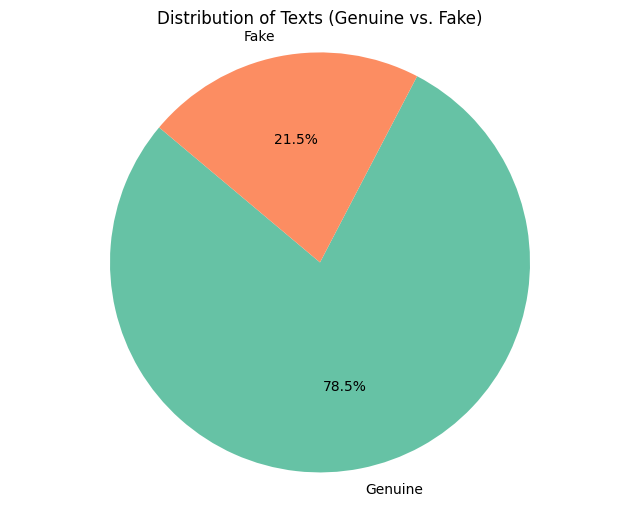

In [2]:
import matplotlib.pyplot as plt

# Data
labels = ['Genuine', 'Fake']
sizes = [41945, 11515]
colors = ['#66c2a5', '#fc8d62']  # Attractive colors

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Texts (Genuine vs. Fake)')
plt.show()


In [1]:
pip install fuzzy-c-means


     ---------------------------------------- 0.0/108.5 kB ? eta -:--:--
     ---------------------------------------- 0.0/108.5 kB ? eta -:--:--
     ---------------------------------------- 0.0/108.5 kB ? eta -:--:--
     ---------------------------------------- 0.0/108.5 kB ? eta -:--:--
     ---------------------------------------- 0.0/108.5 kB ? eta -:--:--
     ----------- ---------------------------- 30.7/108.5 kB ? eta -:--:--
     -------------- ------------------------ 41.0/108.5 kB 1.9 MB/s eta 0:00:01
     -------------------- ---------------- 61.4/108.5 kB 648.1 kB/s eta 0:00:01
     --------------------------- --------- 81.9/108.5 kB 573.4 kB/s eta 0:00:01
     ------------------------------------ 108.5/108.5 kB 448.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/409.5 kB ? eta -:--:--
   ------ --------------------------------- 61.4/409.5 kB 1.1 MB/s eta 0:00:01
   ------ --------------------------------- 61.4/409.5 kB 1.1 MB/s eta 0:00:01
   -------- 

FUZZY


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from fcmeans import FCM

# Load the processed dataset
df = pd.read_csv('threshold.csv')

# Define the threshold conditions for genuine reviews
genuine_thresholds = {
    'rule1_threshold': 1,  # RULE 1 above threshold
    'rule2_threshold': 1,  # RULE 2 above threshold
    'rule3_threshold': 0,  # RULE 3 below threshold
    'rule4_threshold': 0,  # RULE 4 below threshold
    'rule5_threshold': 1,  # RULE 5 above threshold
    'rule6_threshold': 0   # RULE 6 below threshold
}

# Define the threshold conditions for fake reviews (inverse of genuine thresholds)
fake_thresholds = {key: 1 - value for key, value in genuine_thresholds.items()}

# Select rule threshold columns as features
features = df[['rule1_threshold', 'rule2_threshold', 'rule3_threshold', 'rule4_threshold', 'rule5_threshold', 'rule6_threshold']].values

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Define the number of clusters
c = 5  # Binary clustering with genuine and fake clusters

# Perform Fuzzy C-Means clustering
fcm = FCM(n_clusters=c, m=2.0)
fcm.fit(features_scaled)

# Get the cluster centers and membership values
cntr = fcm.centers
u = fcm.u

# Convert thresholds to numpy arrays for distance calculation
genuine_threshold_values = np.array(list(genuine_thresholds.values()))
fake_threshold_values = np.array(list(fake_thresholds.values()))

# Calculate the distance of each cluster center from the genuine and fake thresholds
distances_to_genuine = np.linalg.norm(cntr - genuine_threshold_values, axis=1)
distances_to_fake = np.linalg.norm(cntr - fake_threshold_values, axis=1)

# Determine which cluster center is closer to the genuine thresholds
genuine_cluster = np.argmin(distances_to_genuine)
fake_cluster = np.argmin(distances_to_fake)

# Assign binary cluster membership based on the closer cluster
cluster_membership = np.argmax(u, axis=1)
cluster_membership_binary = [1 if cluster == genuine_cluster else 0 for cluster in cluster_membership]

# Add the binary cluster membership to the dataframe
df['binary_cluster'] = cluster_membership_binary

# Save the results to a CSV file
df.to_csv('binary_clusters.csv', index=False)

# Print the results
print("Cluster Centers:")
print(cntr)
print(f"Genuine cluster: {genuine_cluster}, Fake cluster: {fake_cluster}")
print(f"Number of genuine reviews: {cluster_membership_binary.count(1)}")
print(f"Number of fake reviews: {cluster_membership_binary.count(0)}")


Cluster Centers:
[[ 0.4919602   1.24475205  0.0430911   0.37266728 -0.58015649  0.        ]
 [-1.63950621 -0.22399801  0.01822142 -2.33910286 -0.25646565  0.        ]
 [ 0.46120968  1.05775736  0.0400571   0.36083988  1.56276384  0.        ]
 [-1.71984731 -0.50701176  0.01759816  0.29418499 -0.38291777  0.        ]
 [ 0.53661934 -0.77055476  0.05247025  0.39466331 -0.58658186  0.        ]]
Genuine cluster: 2, Fake cluster: 4
Number of genuine reviews: 12241
Number of fake reviews: 41219


BERT

In [2]:
pip install transformers torch pandas scikit-learn


     ---------------------------------------- 0.0/43.6 kB ? eta -:--:--
     --------- ------------------------------ 10.2/43.6 kB ? eta -:--:--
     ----------------- -------------------- 20.5/43.6 kB 129.6 kB/s eta 0:00:01
     ----------------- -------------------- 20.5/43.6 kB 129.6 kB/s eta 0:00:01
     ----------------------------------- -- 41.0/43.6 kB 178.6 kB/s eta 0:00:01
     -------------------------------------- 43.6/43.6 kB 177.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.3 MB 1.7 MB/s eta 0:00:06
   - -------------------------------------- 0.3/9.3 MB 3.2 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/9.3 MB 3.7 MB/s eta 0:00:03
   -- ------------------------------------- 0.6/9.3 MB 3.6 MB/s eta 0:00:03
   --- ------------------------------------ 0.9/9.3 MB 3.9 MB/s eta 0:00:03
   ----- ---------------------------------- 1.3/9.3 MB 4.2 MB/s eta 0:00:02
   ------ 


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   -------------- ------------------------- 83.3/228.5 MB 2.9 MB/s eta 0:00:50
   -------------- ------------------------- 83.4/228.5 MB 2.9 MB/s eta 0:00:51
   -------------- ------------------------- 83.6/228.5 MB 2.9 MB/s eta 0:00:51
   -------------- ------------------------- 83.7/228.5 MB 2.9 MB/s eta 0:00:51
   -------------- ------------------------- 83.7/228.5 MB 2.8 MB/s eta 0:00:51
   -------------- ------------------------- 83.7/228.5 MB 2.8 MB/s eta 0:00:52
   -------------- ------------------------- 83.8/228.5 MB 2.8 MB/s eta 0:00:52
   -------------- ------------------------- 83.8/228.5 MB 2.8 MB/s eta 0:00:53
   -------------- ------------------------- 83.9/228.5 MB 2.8 MB/s eta 0:00:53
   -------------- ------------------------- 83.9/228.5 MB 2.8 MB/s eta 0:00:53
   -------------- ------------------------- 84.0/228.5 MB 2.8 MB/s eta 0:00:53
   -------------- ------------------------- 84.1/228.5 MB 2.8 MB/s eta 0:00:53
   -------------- ------------------------- 84.1/228

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

# Load the dataset
df = pd.read_csv('threshold.csv')

# Convert 'genuine' and 'fake' labels to numerical labels
df['target'] = df['target'].map({'genuine': 1, 'fake': 0})

# Split the dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

# Convert to torch tensors
train_inputs = torch.tensor(train_encodings['input_ids'])
train_masks = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(train_labels.values)

test_inputs = torch.tensor(test_encodings['input_ids'])
test_masks = torch.tensor(test_encodings['attention_mask'])
test_labels = torch.tensor(test_labels.values)

# Create DataLoader objects
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=16)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=16)

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * 3  # 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training function
def train_model():
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")

# Evaluation function
def evaluate_model():
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, axis=1).tolist())
            true_labels.extend(b_labels.tolist())
    print("Accuracy:", accuracy_score(true_labels, preds))
    print("Classification Report:")
    print(classification_report(true_labels, preds))

# Train and evaluate the model
for epoch in range(3):  # 3 epochs
    print(f"Epoch {epoch + 1}")
    train_model()
    evaluate_model()

# Save the model
model.save_pretrained('bert_model')
tokenizer.save_pretrained('bert_model')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\Shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Shiva\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1


KeyboardInterrupt: 

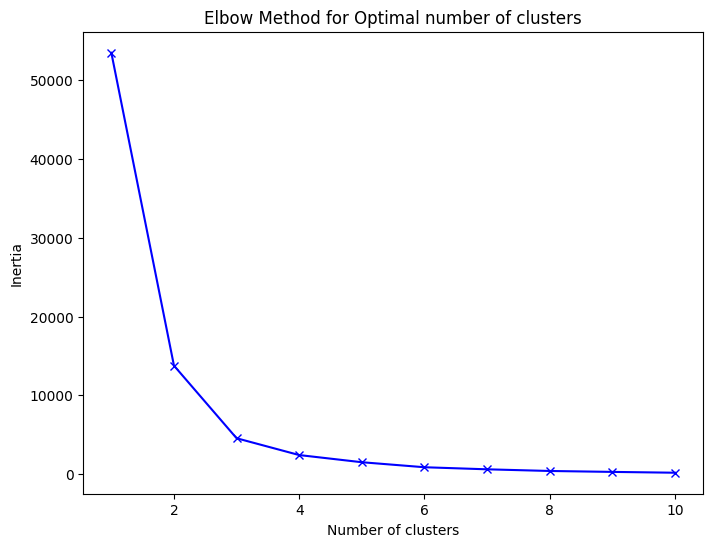

Cluster Centers:
[[-1.51203472  0.05603921 -0.01302627 -1.81877155 -0.09906975  0.        ]
 [ 0.31672926  0.933219    0.02064154  0.33188262  1.01074522  0.        ]
 [ 0.46167346 -0.65132489  0.0431211   0.37931553 -0.54898997  0.        ]]
Cluster Membership:
[2 1 1 ... 1 1 2]
Number of reviews in each cluster: [ 9366 20877 23217]


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from fcmeans import FCM
import matplotlib.pyplot as plt

# Load the processed dataset
df = pd.read_csv('threshold.csv')

# Select rule threshold columns as features
features = df[['rule1_threshold', 'rule2_threshold', 'rule3_threshold', 'rule4_threshold', 'rule5_threshold', 'rule6_threshold']].values

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
inertia = []
K = range(1, 11)

for k in K:
    fcm = FCM(n_clusters=k, m=2.0)
    fcm.fit(features_scaled)
    # Calculate inertia (sum of squared distances to the closest centroid)
    distances = np.min(fcm.u, axis=1)
    inertia.append(np.sum(distances))

# Plot the inertia values to find the "elbow"
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal number of clusters')
plt.show()

# Based on the plot, choose the optimal number of clusters
optimal_clusters = 3  # Replace this with the chosen number from the plot

# Train the Fuzzy C-Means model with the optimal number of clusters
fcm = FCM(n_clusters=optimal_clusters, m=2.0)
fcm.fit(features_scaled)

# Get the cluster centers and membership values
cntr = fcm.centers
u = fcm.u

# Assign cluster membership based on the highest membership value
cluster_membership = np.argmax(u, axis=1)

# Add the cluster membership to the dataframe
df['cluster'] = cluster_membership

# Save the results to a CSV file
df.to_csv('clusters.csv', index=False)

# Print the results
print("Cluster Centers:")
print(cntr)
print(f"Cluster Membership:\n{cluster_membership}")
print(f"Number of reviews in each cluster: {np.bincount(cluster_membership)}")


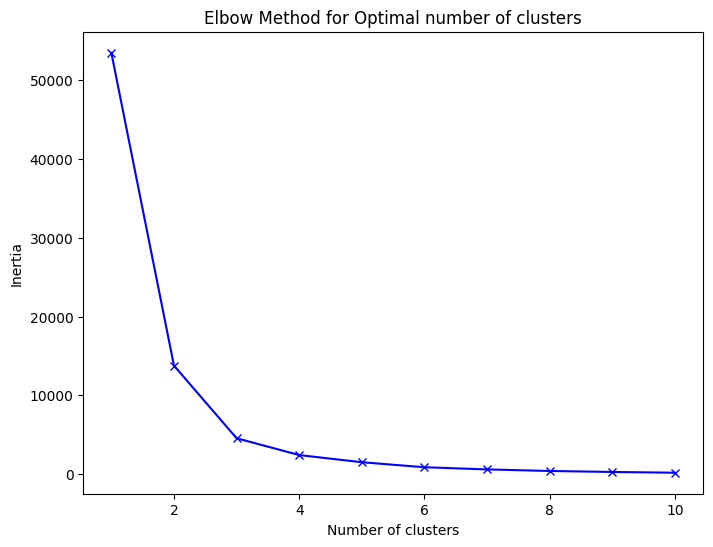

Cluster Centers:
[[ 0.46167346 -0.65132487  0.0431211   0.37931553 -0.54898998  0.        ]
 [ 0.31672927  0.93321897  0.02064154  0.33188262  1.01074532  0.        ]
 [-1.51203472  0.05603922 -0.01302627 -1.81877151 -0.09906977  0.        ]]
Cluster Membership:
[0 1 1 ... 1 1 0]
Number of reviews in each cluster: [23217 20877  9366]
Accuracy: 0.88
Precision: 0.90
Recall: 0.95
F1 Score: 0.92


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from fcmeans import FCM
from scipy.stats import mode
import matplotlib.pyplot as plt

# Load the processed dataset
df = pd.read_csv('threshold.csv')

# Select rule threshold columns as features
features = df[['rule1_threshold', 'rule2_threshold', 'rule3_threshold', 'rule4_threshold', 'rule5_threshold', 'rule6_threshold']].values

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
inertia = []
K = range(1, 11)

for k in K:
    fcm = FCM(n_clusters=k, m=2.0)
    fcm.fit(features_scaled)
    # Calculate inertia (sum of squared distances to the closest centroid)
    distances = np.min(fcm.u, axis=1)
    inertia.append(np.sum(distances))

# Plot the inertia values to find the "elbow"
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal number of clusters')
plt.show()

# Based on the plot, choose the optimal number of clusters
optimal_clusters = 3  # Replace this with the chosen number from the plot

# Train the Fuzzy C-Means model with the optimal number of clusters
fcm = FCM(n_clusters=optimal_clusters, m=2.0)
fcm.fit(features_scaled)

# Get the cluster centers and membership values
cntr = fcm.centers
u = fcm.u

# Assign cluster membership based on the highest membership value
cluster_membership = np.argmax(u, axis=1)

# Add the cluster membership to the dataframe
df['cluster'] = cluster_membership

# Save the results to a CSV file
df.to_csv('clusters.csv', index=False)

# Print the results
print("Cluster Centers:")
print(cntr)
print(f"Cluster Membership:\n{cluster_membership}")
print(f"Number of reviews in each cluster: {np.bincount(cluster_membership)}")

# Assuming we have true labels in the dataframe (1 for genuine, 0 for fake)
# Convert true labels to 1 for genuine and 0 for fake
true_labels = df['target'].map({'genuine': 1, 'fake': 0}).values  # Adjust this according to the actual column name

# Map each cluster to the majority class label
cluster_labels = {}
for cluster in range(optimal_clusters):
    labels_in_cluster = true_labels[cluster_membership == cluster]
    if len(labels_in_cluster) > 0:
        majority_label = mode(labels_in_cluster, keepdims=True).mode[0]
        cluster_labels[cluster] = majority_label
    else:
        cluster_labels[cluster] = 0  # Assign a default value when no labels are present

# Assign predicted labels based on cluster majority
predicted_labels = np.array([cluster_labels[cluster] for cluster in cluster_membership])

# Evaluate the model
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
